<a href="https://colab.research.google.com/github/nalbaq/TS-paleointensity/blob/main/INFO_5_Ma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
from scipy.interpolate import UnivariateSpline # Keep UnivariateSpline as it was used in the original function
from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from google.colab import drive
import shutil

# Manejo de cartopy - intentar importar, si no está disponible usar matplotlib básico
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_AVAILABLE = True
    print("Cartopy disponible - usando mapas geográficos")
except ImportError:
    CARTOPY_AVAILABLE = False
    print("Cartopy no disponible - usando matplotlib básico")

import warnings
warnings.filterwarnings('ignore')

# 0. Load data VADM PINT
try:
    drive.mount('/content/drive', force_remount=True)
    # ¡IMPORTANTE! Ajusta esta ruta a la ubicación REAL de tu archivo en Google Drive
    file_path = '/content/drive/MyDrive/Paleomag_data_python/PINTv811.xlsx'
    pint = pd.read_excel(file_path)
    print(f"Initial PINT data length: {len(pint)}")
except (FileNotFoundError, ModuleNotFoundError) as e:
    print(f"Error al cargar el archivo: {e}")
    # Crear datos de ejemplo para pruebas si falla la carga

# ------------------------ FILTER BY SAMPLE'S AGE ----------------------
filtro_edad = 5.00
# ----------------------- FILTER BY SAMPLE'S Qpi CRITERIA ----------------------
#filtro_qpi_min = 3.0
pint_10my = pint[(pint['AGE'] <= filtro_edad)]
#& (pint['QPI'] > filtro_qpi_min)] # QPI threshold value, age and volcanic samples
print(f"PINT data length after 5 Ma age filter: {len(pint_10my)}")

# ----------------------- FILTER BY SAMPLE'S TYPE ----------------------
igneous_groups = ['Volcanic', 'volcanic', 'Plutonic', 'Intrusive']
pint_10my = pint_10my[pint_10my['GROUP'].isin(igneous_groups)]
print(f"PINT data length after igneous group filter: {len(pint_10my)}")

# Preparar datos VADM con las columnas correctas
data_vadm = pint_10my.copy()
data_vadm.sort_values(by='AGE', ascending=True, inplace=True)

# Completar valores VADM faltantes usando VDM y VDM/VADM
data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].notnull(), 'VADM'] = data_vadm['VDM']
data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].isnull() & data_vadm['VDM/VADM'].notnull(), 'VADM'] = data_vadm['VDM/VADM']

# Filtrar solo las columnas necesarias y eliminar valores nulos
# Filtrar solo las columnas necesarias incluyendo CONTINENT
required_columns = ['AGE', 'VADM', 'SLAT', 'SLONG', 'CONTINENT']
available_columns = [col for col in required_columns if col in data_vadm.columns]
data_vadm = data_vadm[available_columns].dropna(subset=['VADM', 'AGE'])
print(f"Longitud final de datos VADM para análisis: {len(data_vadm)}")

# Mostrar información del dataset final
print("\nInformación del dataset final:")
print(f"Columnas disponibles: {list(data_vadm.columns)}")
print(f"Rango de coordenadas:")
print(f"  - Latitud: {data_vadm['SLAT'].min():.2f}° a {data_vadm['SLAT'].max():.2f}°")
print(f"  - Longitud: {data_vadm['SLONG'].min():.2f}° a {data_vadm['SLONG'].max():.2f}°")
print(f"  - Edad: {data_vadm['AGE'].min():.2f} a {data_vadm['AGE'].max():.2f} Ma")
print(f"  - VADM: {data_vadm['VADM'].min():.2f} a {data_vadm['VADM'].max():.2f} ZAm²")



Cartopy disponible - usando mapas geográficos
Mounted at /content/drive
Initial PINT data length: 4648
PINT data length after 5 Ma age filter: 2036
PINT data length after igneous group filter: 1923
Longitud final de datos VADM para análisis: 1855

Información del dataset final:
Columnas disponibles: ['AGE', 'VADM', 'SLAT', 'SLONG', 'CONTINENT']
Rango de coordenadas:
  - Latitud: -78.40° a 70.99°
  - Longitud: -114.38° a 359.00°
  - Edad: 0.05 a 4.84 Ma
  - VADM: 0.20 a 27.55 ZAm²


Longitud final de datos VADM para análisis por continentes: 1855
INICIANDO ANÁLISIS GEOGRÁFICO POR CONTINENTES
Datos disponibles para análisis: 1855 registros

Creando resumen por continentes...
Resumen creado para 7 continentes
Resumen por continentes creado con 7 continentes

1. Creando mapa geográfico por continentes...
   - Posición = Centro de cada continente
   - Tamaño de círculo = Número total de muestras por continente
   - Colores = VADM promedio por continente
   - Símbolos = Todos círculos (sin distinción por edad)
Creando mapa por continentes con 7 continentes


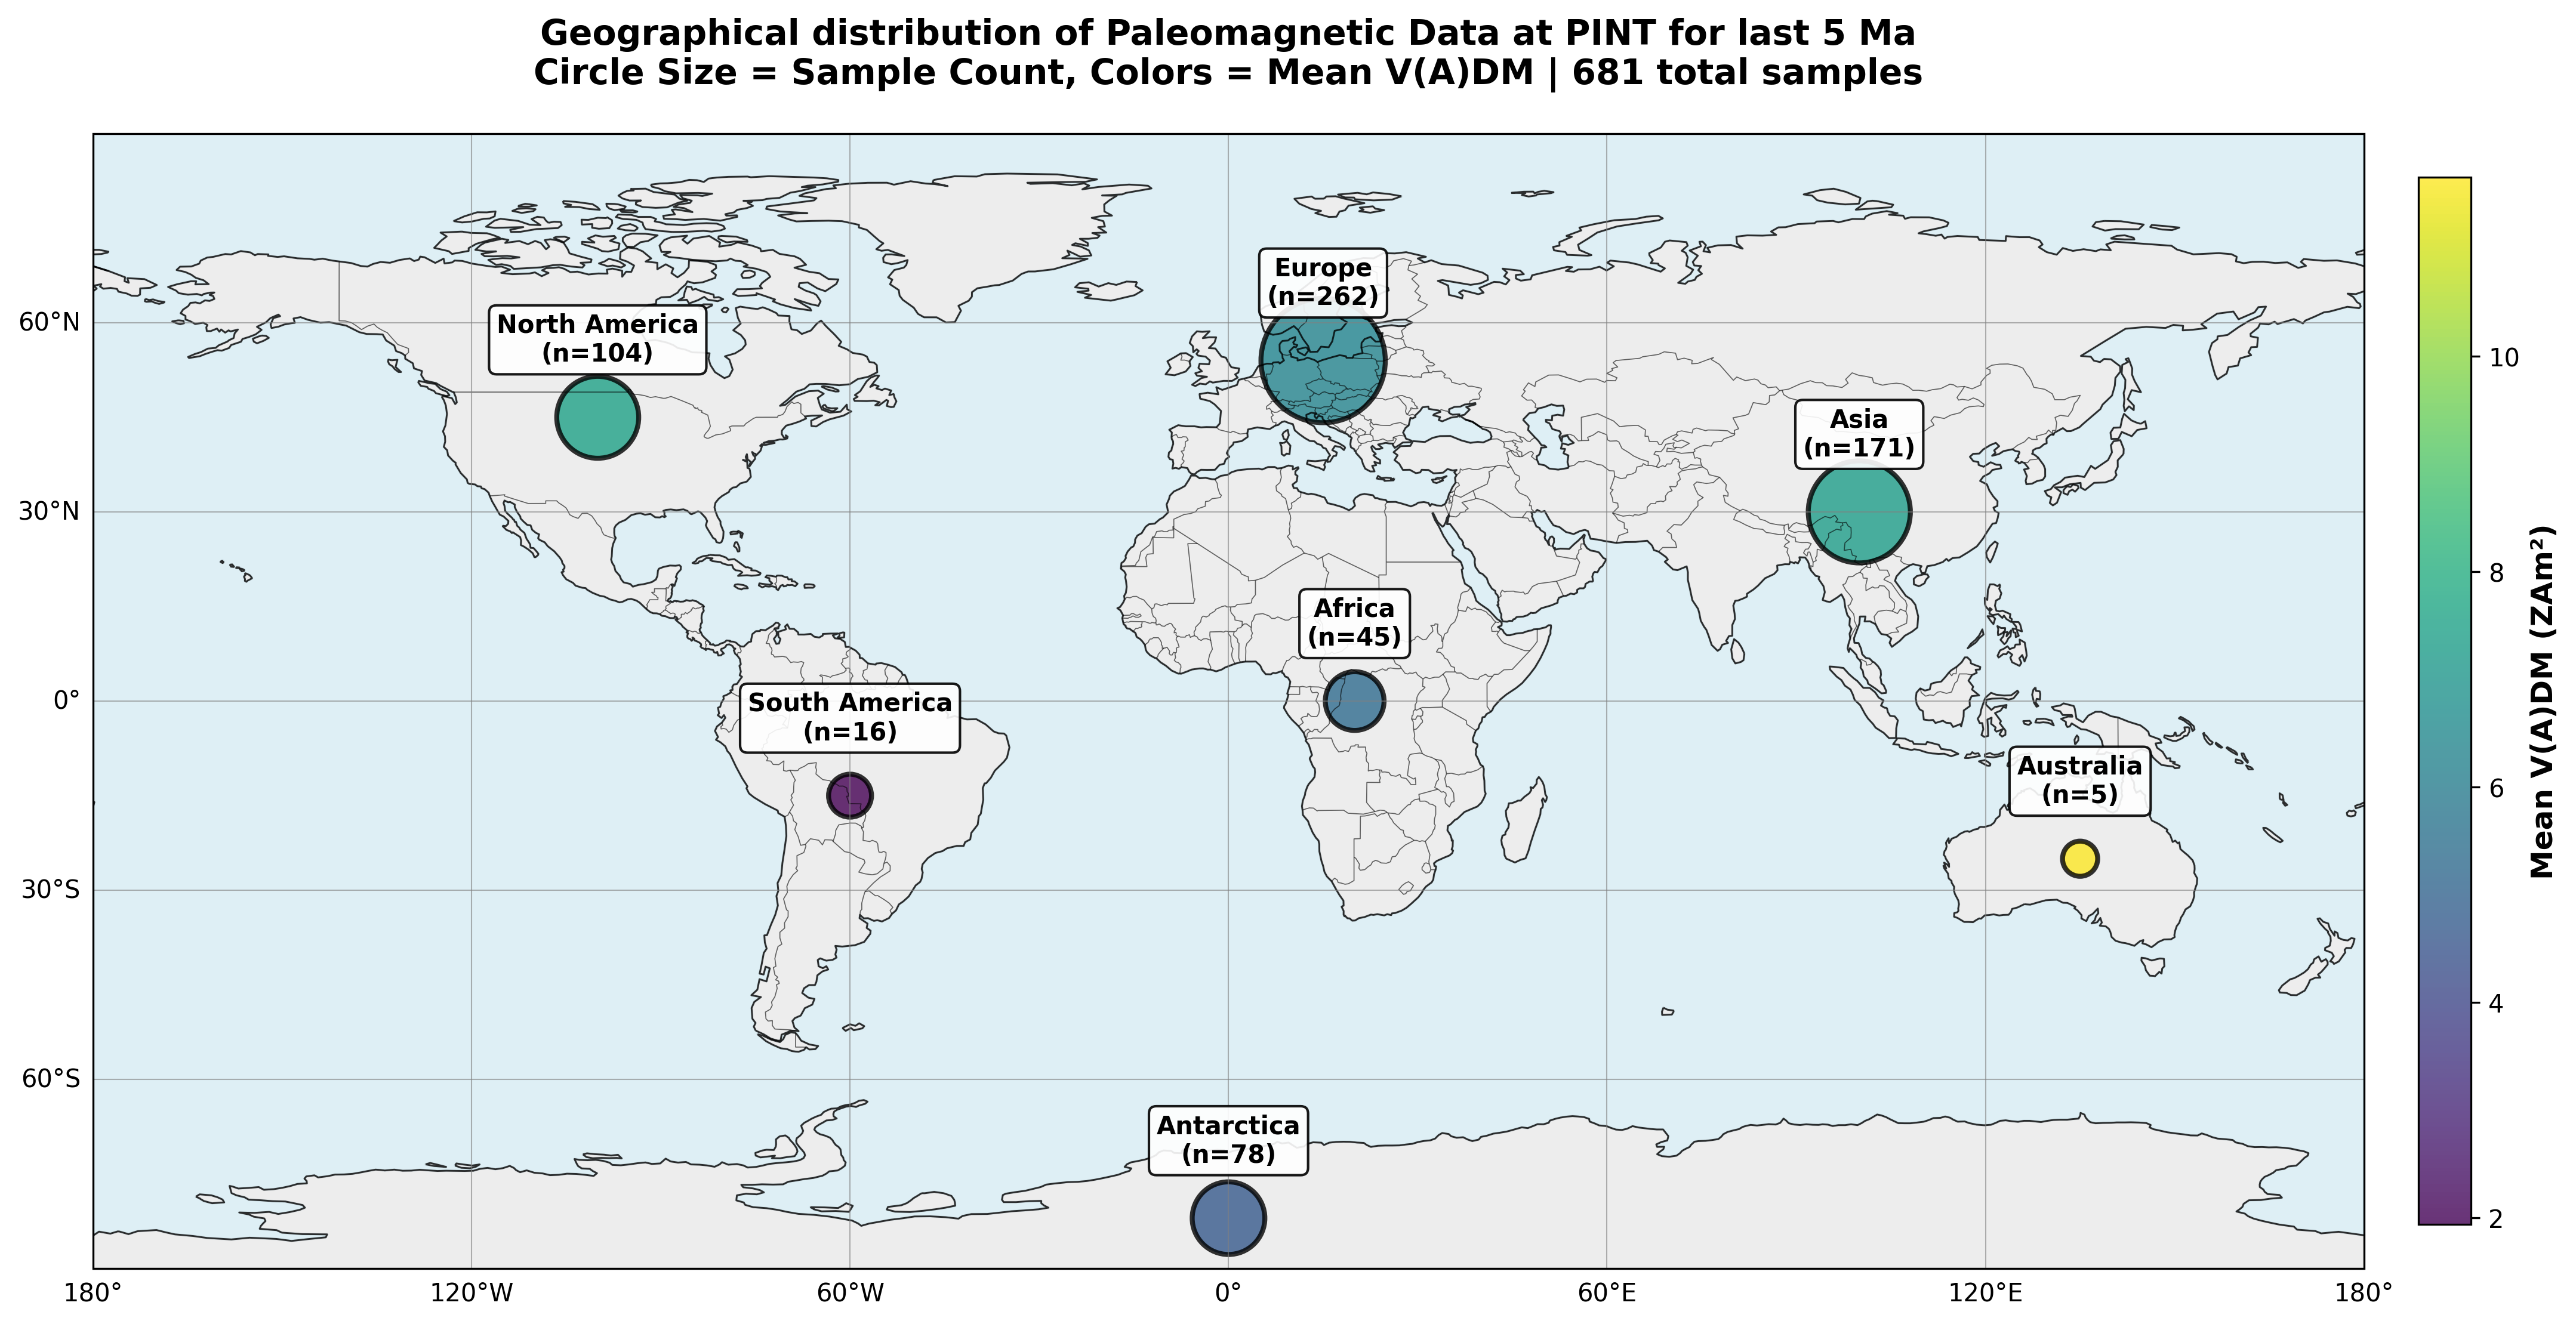


2. Creando histograma de distribución de edades...
Creando histograma con 1855 datos de edad válidos


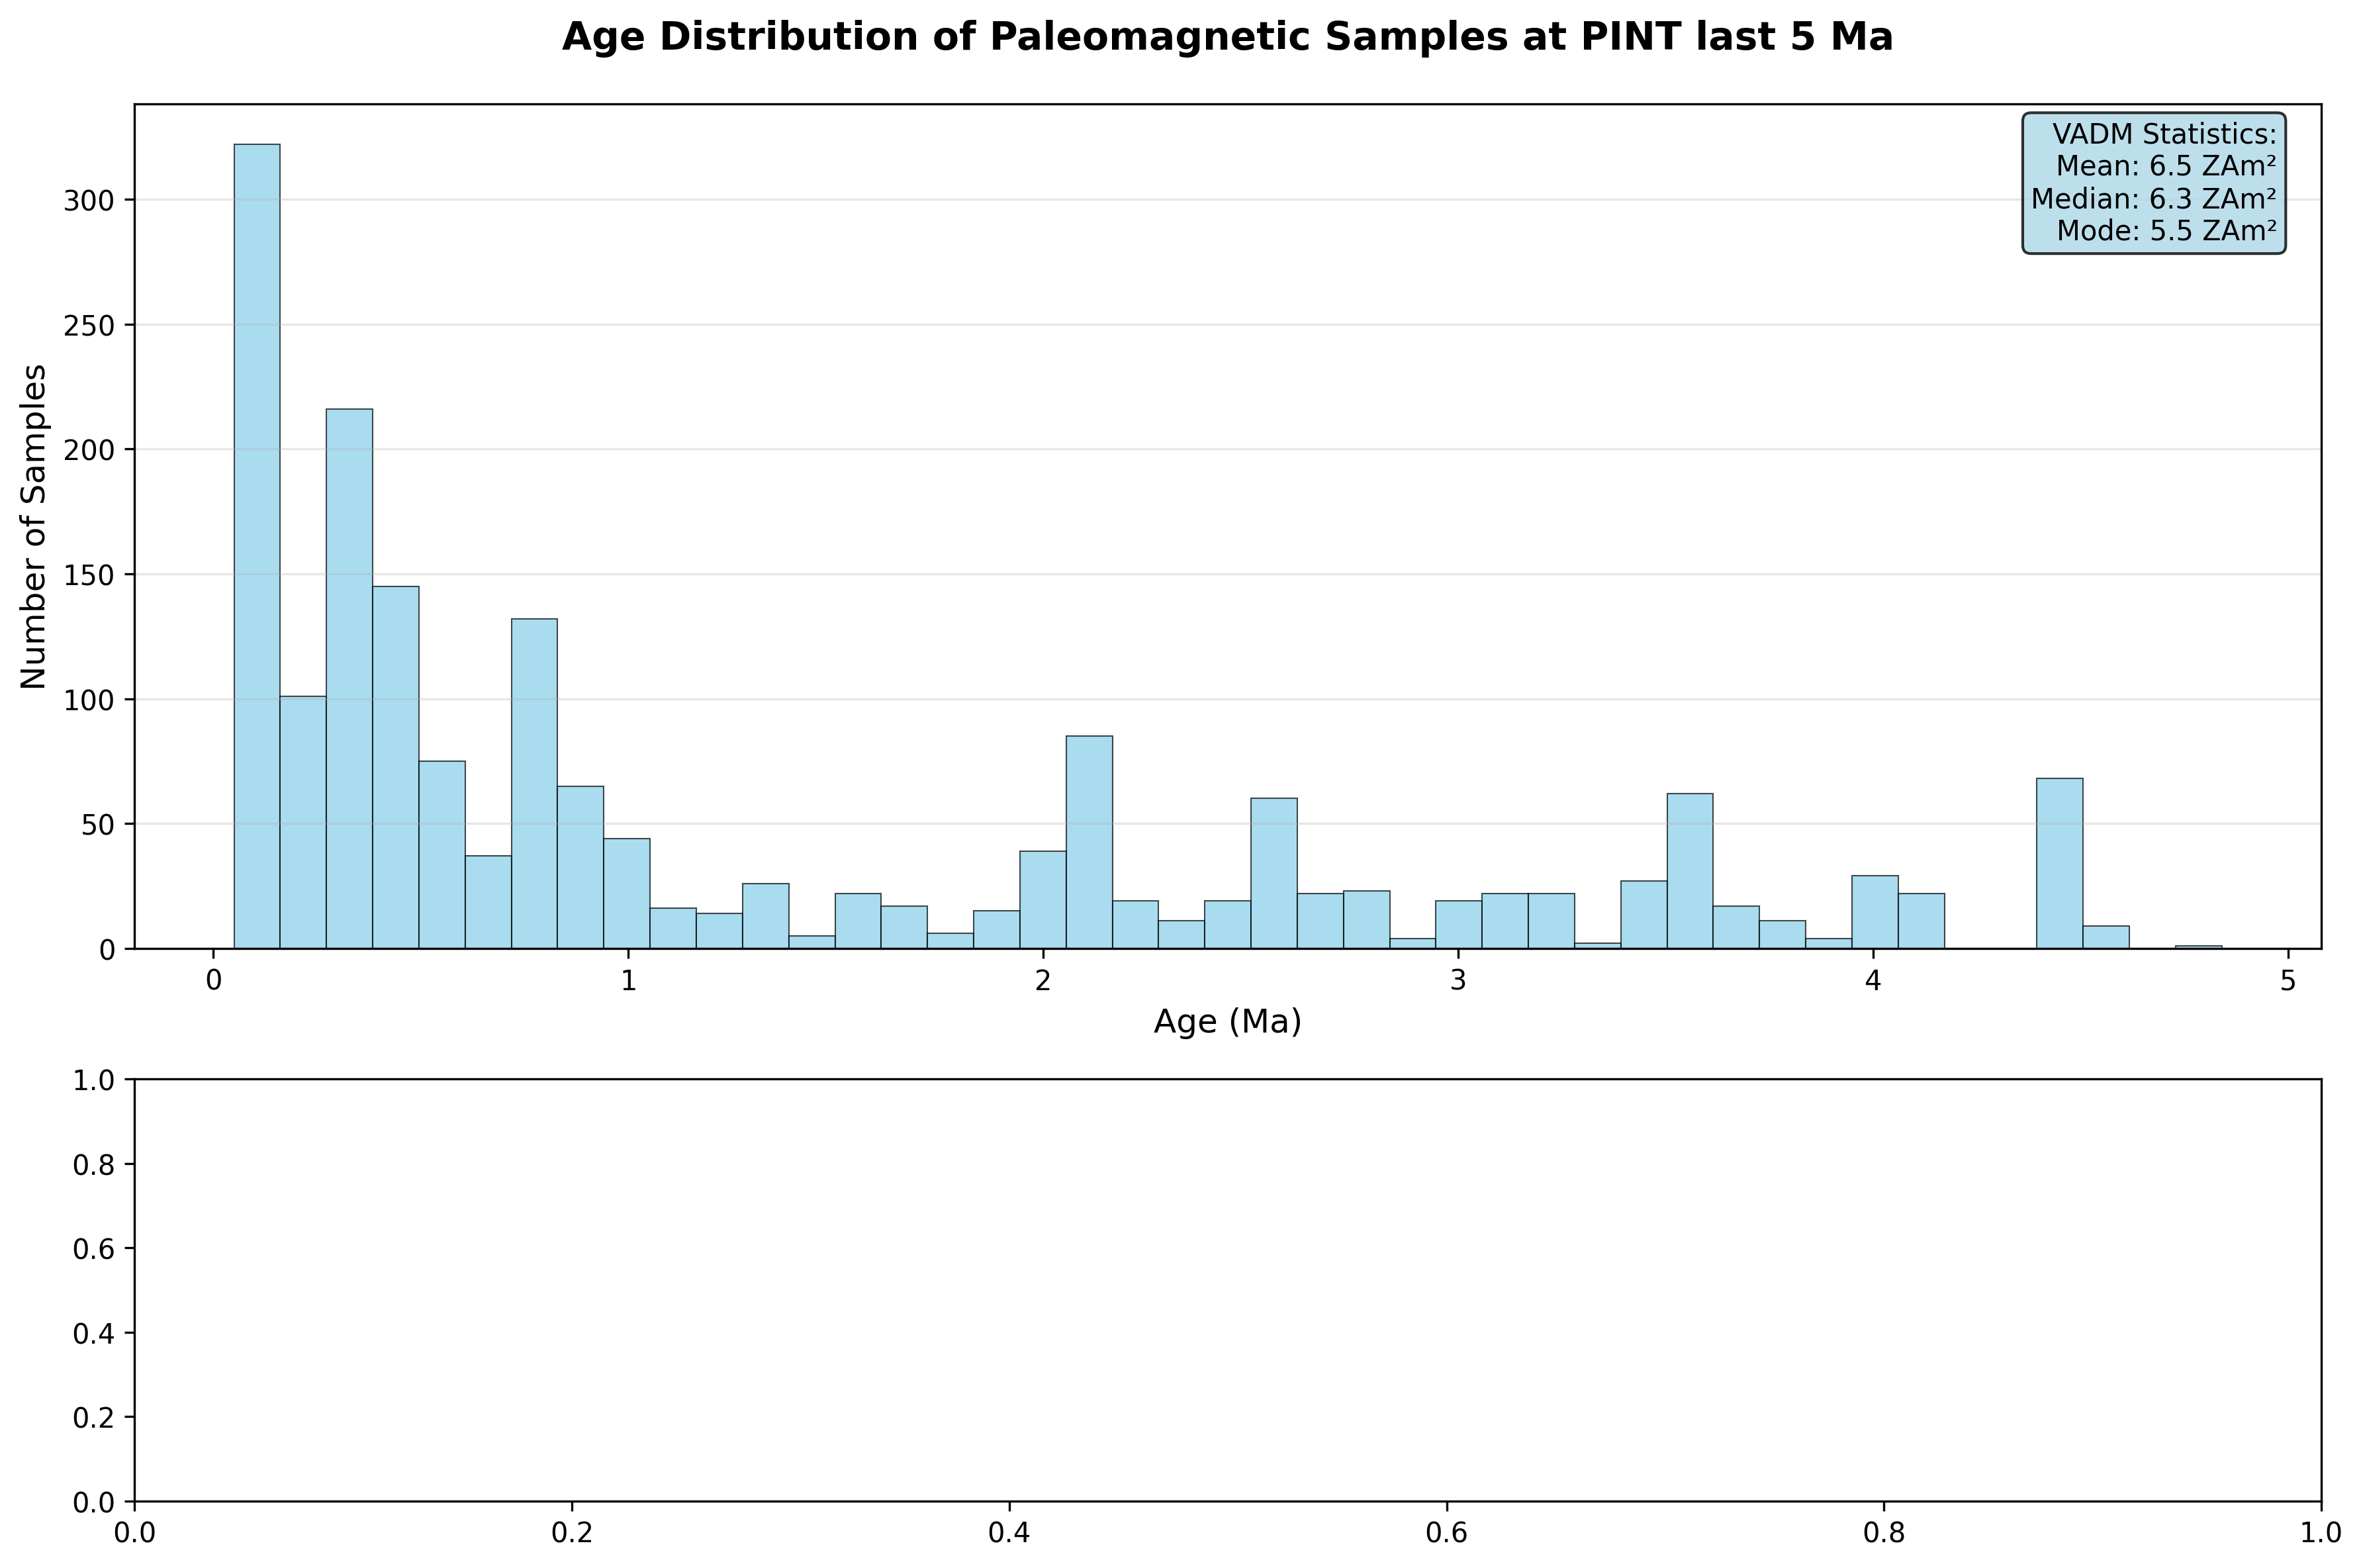


3. ESTADÍSTICAS RESUMIDAS POR CONTINENTES:
------------------------------------------------------------
RESUMEN POR CONTINENTE:

EUROPE:
  - Muestras: 262
  - VADM promedio: 6.3 ± 2.4 ZAm²
  - VADM rango: 1.0 - 15.4 ZAm²
  - Edad promedio: 1.54 Ma
  - Edad rango: 0.05 - 4.40 Ma

ASIA:
  - Muestras: 171
  - VADM promedio: 7.3 ± 4.0 ZAm²
  - VADM rango: 0.8 - 25.0 ZAm²
  - Edad promedio: 1.04 Ma
  - Edad rango: 0.07 - 4.40 Ma

NORTH AMERICA:
  - Muestras: 104
  - VADM promedio: 7.5 ± 3.2 ZAm²
  - VADM rango: 1.1 - 16.6 ZAm²
  - Edad promedio: 1.40 Ma
  - Edad rango: 0.06 - 4.84 Ma

ANTARCTICA:
  - Muestras: 78
  - VADM promedio: 4.6 ± 2.4 ZAm²
  - VADM rango: 0.9 - 13.5 ZAm²
  - Edad promedio: 1.29 Ma
  - Edad rango: 0.06 - 4.47 Ma

AFRICA:
  - Muestras: 45
  - VADM promedio: 5.3 ± 3.4 ZAm²
  - VADM rango: 0.9 - 18.3 ZAm²
  - Edad promedio: 2.08 Ma
  - Edad rango: 0.25 - 2.34 Ma

SOUTH AMERICA:
  - Muestras: 16
  - VADM promedio: 1.9 ± 2.1 ZAm²
  - VADM rango: 0.2 - 8.4 ZAm²
  - Edad pr

In [ ]:
# Solo requerir CONTINENT si está disponible
if 'CONTINENT' in data_vadm.columns:
    data_vadm = data_vadm.dropna(subset=['CONTINENT'])
    print(f"Longitud final de datos VADM para análisis por continentes: {len(data_vadm)}")
else:
    print("ADVERTENCIA: Columna CONTINENT no disponible, usando coordenadas individuales")
    data_vadm = data_vadm.dropna(subset=['SLAT', 'SLONG'])
    print(f"Longitud final de datos VADM para análisis: {len(data_vadm)}")

# ======================== COORDENADAS CENTRALES DE CONTINENTES ========================

CONTINENT_COORDINATES = {
    'North America': {'lat': 45.0, 'lon': -100.0, 'name': 'North America'},
    'South America': {'lat': -15.0, 'lon': -60.0, 'name': 'South America'},
    'Europe': {'lat': 54.0, 'lon': 15.0, 'name': 'Europe'},
    'Asia': {'lat': 30.0, 'lon': 100.0, 'name': 'Asia'},
    'Africa': {'lat': 0.0, 'lon': 20.0, 'name': 'Africa'},
    'Australia': {'lat': -25.0, 'lon': 135.0, 'name': 'Australia'},
    'Antarctica': {'lat': -82.0, 'lon': 0.0, 'name': 'Antarctica'},
    'Oceania': {'lat': -20.0, 'lon': 175.0, 'name': 'Oceania'},
    # Agregar variaciones comunes de nombres
    'N America': {'lat': 45.0, 'lon': -100.0, 'name': 'North America'},
    'S America': {'lat': -15.0, 'lon': -60.0, 'name': 'South America'},
    'N. America': {'lat': 45.0, 'lon': -100.0, 'name': 'North America'},
    'S. America': {'lat': -15.0, 'lon': -60.0, 'name': 'South America'},
    'Antarctic': {'lat': -82.0, 'lon': 0.0, 'name': 'Antarctica'},
}

def normalize_continent_name(continent):
    """
    Normaliza los nombres de continentes para estandarizarlos.
    """
    if pd.isna(continent):
        return 'Unknown'

    continent_str = str(continent).strip()

    # Mapeo de nombres comunes
    name_mapping = {
        'N America': 'North America',
        'N. America': 'North America',
        'S America': 'South America',
        'S. America': 'South America',
        'Antarctic': 'Antarctica',
        'Oceania': 'Australia',
    }

    return name_mapping.get(continent_str, continent_str)

def get_continent_coordinates(continent):
    """
    Obtiene las coordenadas centrales de un continente.
    """
    normalized = normalize_continent_name(continent)
    return CONTINENT_COORDINATES.get(normalized, {'lat': 0.0, 'lon': 0.0, 'name': 'Unknown'})

# ======================== FUNCIONES AUXILIARES MODIFICADAS ========================

def create_continent_summary(df):
    """
    Crea un resumen de datos por continente (sin agrupar por edad).
    """
    try:
        if 'CONTINENT' not in df.columns:
            raise ValueError("Columna CONTINENT no disponible")

        # Normalizar nombres de continentes
        df_summary = df.copy()
        df_summary['CONTINENT_NORM'] = df_summary['CONTINENT'].apply(normalize_continent_name)

        # Agregar coordenadas de continentes
        continent_coords = df_summary['CONTINENT_NORM'].apply(get_continent_coordinates)
        df_summary['continent_lat'] = [coord['lat'] for coord in continent_coords]
        df_summary['continent_lon'] = [coord['lon'] for coord in continent_coords]
        df_summary['continent_name'] = [coord['name'] for coord in continent_coords]

        # Crear resumen por continente (SIN agrupar por edad)
        summary = df_summary.groupby(['continent_name']).agg({
            'VADM': ['count', 'mean', 'std', 'min', 'max'],
            'AGE': ['mean', 'min', 'max'],
            'continent_lat': 'first',
            'continent_lon': 'first'
        }).reset_index()

        # Aplanar columnas multinivel
        summary.columns = ['continent', 'sample_count', 'vadm_mean', 'vadm_std', 'vadm_min', 'vadm_max',
                          'age_mean', 'age_min', 'age_max', 'continent_lat', 'continent_lon']

        # Llenar NaN en vadm_std con 0
        summary['vadm_std'] = summary['vadm_std'].fillna(0)

        # Filtrar continentes desconocidos
        summary = summary[summary['continent'] != 'Unknown']

        print(f"Resumen creado para {len(summary)} continentes")

        return summary

    except Exception as e:
        print(f"Error creando resumen por continente: {e}")
        return pd.DataFrame()

def create_continent_map_cartopy(summary_df, figsize=(16, 12), dpi=300):
    """
    Crea un mapa por continentes usando Cartopy (solo círculos).
    """
    try:
        if summary_df.empty:
            raise ValueError("DataFrame de resumen está vacío")

        print(f"Creando mapa por continentes con {len(summary_df)} continentes")

        # Configurar la figura
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

        # Configurar características geográficas
        ax.add_feature(cfeature.COASTLINE, linewidth=0.7, alpha=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, alpha=0.6)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.4)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.4)

        # Configurar grilla
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                         linewidth=0.5, alpha=0.6, color='gray')
        gl.top_labels = False
        gl.right_labels = False

        # Configurar escalas para tamaño y color
        min_samples = summary_df['sample_count'].min()
        max_samples = summary_df['sample_count'].max()
        min_size = 200
        max_size = 2500

        # Normalizar tamaños (escala proporcional al número de muestras)
        if max_samples > min_samples:
            size_scale = (summary_df['sample_count'] - min_samples) / (max_samples - min_samples)
            sizes = min_size + size_scale * (max_size - min_size)
        else:
            sizes = np.full(len(summary_df), (min_size + max_size) / 2)

        # Configurar mapa de colores para VADM
        vmin, vmax = summary_df['vadm_mean'].min(), summary_df['vadm_mean'].max()
        cmap = plt.cm.viridis

        # Crear scatter plot con círculos únicamente
        scatter = ax.scatter(summary_df['continent_lon'], summary_df['continent_lat'],
                           c=summary_df['vadm_mean'], s=sizes,
                           marker='o',  # Solo círculos
                           cmap=cmap, vmin=vmin, vmax=vmax,
                           alpha=0.8, transform=ccrs.PlateCarree(),
                           edgecolors='black', linewidth=2)

        # Agregar etiquetas de continentes
        for _, cont in summary_df.iterrows():
            # Posicionar texto ligeramente arriba del punto
            text_lat = cont['continent_lat'] + 8
            ax.text(cont['continent_lon'], text_lat,
                   f"{cont['continent']}\n(n={cont['sample_count']})",
                   transform=ccrs.PlateCarree(), ha='center', va='bottom',
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

        # Agregar barra de colores
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, pad=0.02, aspect=20)
        cbar.set_label('Mean V(A)DM (ZAm²)', fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)

        # Configurar título
        total_samples = summary_df['sample_count'].sum()
        ax.set_title('Geographical distribution of Paleomagnetic Data at PINT for last 5 Ma\n' +
                    f'Circle Size = Sample Count, Colors = Mean V(A)DM | {total_samples} total samples',
                    fontsize=14, fontweight='bold', pad=20)

        # Leyenda de tamaños
        # size_legend_text = (f'Circle Size Legend:\n'
        #                    f'Smallest: {min_samples} samples\n'
        #                    f'Largest: {max_samples} samples')
        # ax.text(0.98, 0.02, size_legend_text, transform=ax.transAxes,
        #        verticalalignment='bottom', horizontalalignment='right',
        #        bbox=dict(boxstyle='round,pad=0.5', facecolor='powderblue', alpha=0.9),
        #        fontsize=10)

        # Estadísticas generales
        #vadm_overall_mean = np.average(summary_df['vadm_mean'], weights=summary_df['sample_count'])
        #age_overall_mean = np.average(summary_df['age_mean'], weights=summary_df['sample_count'])

        #stats_text = (f'Weighted Mean VADM: {vadm_overall_mean:.1f} ZAm²\n'
                    #  f'Weighted Mean Age: {age_overall_mean:.2f} Ma\n'
                    #  f'VADM Range: {vmin:.1f} - {vmax:.1f} ZAm²\n'
                    # )

        #ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
              #  verticalalignment='top', horizontalalignment='left',
              #  bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.9),
              #  fontsize=9)

        # Configurar límites del mapa
        ax.set_global()

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error creando mapa por continentes con Cartopy: {e}")
        raise

def create_continent_map_basic(summary_df, figsize=(16, 12), dpi=300):
    """
    Crea un mapa por continentes usando matplotlib básico (solo círculos).
    """
    try:
        if summary_df.empty:
            raise ValueError("DataFrame de resumen está vacío")

        print(f"Creando mapa básico por continentes con {len(summary_df)} continentes")

        # Configurar la figura
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        # Configurar escalas para tamaño y color
        min_samples = summary_df['sample_count'].min()
        max_samples = summary_df['sample_count'].max()
        min_size = 200
        max_size = 2500

        # Normalizar tamaños
        if max_samples > min_samples:
            size_scale = (summary_df['sample_count'] - min_samples) / (max_samples - min_samples)
            sizes = min_size + size_scale * (max_size - min_size)
        else:
            sizes = np.full(len(summary_df), (min_size + max_size) / 2)

        # Configurar mapa de colores para VADM
        vmin, vmax = summary_df['vadm_mean'].min(), summary_df['vadm_mean'].max()
        cmap = plt.cm.viridis

        # Crear scatter plot con círculos únicamente
        scatter = ax.scatter(summary_df['continent_lon'], summary_df['continent_lat'],
                           c=summary_df['vadm_mean'], s=sizes,
                           marker='o',  # Solo círculos
                           cmap=cmap, vmin=vmin, vmax=vmax,
                           alpha=0.8, edgecolors='black', linewidth=2)

        # Agregar etiquetas de continentes
        for _, cont in summary_df.iterrows():
            # Posicionar texto ligeramente arriba del punto
            text_lat = cont['continent_lat'] + 8
            ax.text(cont['continent_lon'], text_lat,
                   f"{cont['continent']}\n(n={cont['sample_count']})",
                   ha='center', va='bottom', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

        # Configurar ejes
        ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
        ax.grid(True, alpha=0.4)

        # Agregar barra de colores
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, pad=0.02, aspect=20)
        cbar.set_label('Mean V(A)DM (ZAm²)', fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)

        # Configurar título
        total_samples = summary_df['sample_count'].sum()
        ax.set_title('Paleomagnetic Data by Continent\n' +
                    f'Circle Size = Sample Count, Colors = Mean V(A)DM | {total_samples} total samples',
                    fontsize=14, fontweight='bold', pad=20)

        # Leyenda de tamaños
        size_legend_text = (f'Circle Size Legend:\n'
                           f'Smallest: {min_samples} samples\n'
                           f'Largest: {max_samples} samples')
        ax.text(0.98, 0.02, size_legend_text, transform=ax.transAxes,
               verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='powderblue', alpha=0.9),
               fontsize=10)

        # Estadísticas generales
        vadm_overall_mean = np.average(summary_df['vadm_mean'], weights=summary_df['sample_count'])
        age_overall_mean = np.average(summary_df['age_mean'], weights=summary_df['sample_count'])

        stats_text = (f'Overall Statistics:\n'
                     f'Weighted Mean V(A)DM: {vadm_overall_mean:.1f} ZAm²\n'
                     f'VADM Range: {vmin:.1f} - {vmax:.1f} ZAm²\n'
                     f'Continents: {len(summary_df)}')

        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.9),
               fontsize=9)

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error creando mapa básico por continentes: {e}")
        raise

def create_continent_map(summary_df, figsize=(16, 12), dpi=300):
    """
    Crea un mapa por continentes, usando Cartopy si está disponible.
    """
    try:
        if CARTOPY_AVAILABLE:
            return create_continent_map_cartopy(summary_df, figsize, dpi)
        else:
            return create_continent_map_basic(summary_df, figsize, dpi)

    except Exception as e:
        print(f"Error creando mapa por continentes: {e}")
        # Crear figura de error
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, f'Error creating continent map:\n{str(e)}',
                transform=ax.transAxes, ha='center', va='center',
                fontsize=12, color='red')
        ax.set_title('Error in Continent Map')
        return fig

def create_age_histogram(df, age_col='AGE', figsize=(12, 8), dpi=300):
    """
    Crea histograma de distribución de edades (sin rangos específicos).
    """
    try:
        # Validar datos de entrada
        if df.empty:
            raise ValueError("DataFrame está vacío")

        if age_col not in df.columns:
            raise ValueError(f"Columna '{age_col}' no encontrada")

        # Limpiar datos de edad
        age_data = df[age_col].dropna()
        age_data = age_data[age_data >= 0]  # Solo edades positivas

        if age_data.empty:
            raise ValueError("No hay datos de edad válidos")

        # Some statistics
        vadm_mean = df['VADM'].mean()
        vadm_median = df['VADM'].median()
        vadm_mode = df['VADM'].mode().iloc[0] if not df['VADM'].mode().empty else vadm_mean
        print(f"Creando histograma con {len(age_data)} datos de edad válidos")

        # Crear la figura
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, dpi=dpi,
                                      gridspec_kw={'height_ratios': [2, 1]})

        # Histograma principal con bins automáticos
        n_bins = min(50, int(np.sqrt(len(age_data))))  # Número óptimo de bins
        counts, bins, patches = ax1.hist(age_data, bins=n_bins, alpha=0.7,
                                        color='skyblue', edgecolor='black', linewidth=0.5)


        # Configurar el gráfico principal
        ax1.set_title('Age Distribution of Paleomagnetic Samples at PINT last 5 Ma',
                     fontsize=14, fontweight='bold', pad=20)
        ax1.set_xlabel('Age (Ma)', fontsize=12)
        ax1.set_ylabel('Number of Samples', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')


        # Texto con estadísticas de VADM
        vadm_stats_text = f'VADM Statistics:\nMean: {vadm_mean:.1f} ZAm²\nMedian: {vadm_median:.1f} ZAm²\nMode: {vadm_mode:.1f} ZAm²'
        ax1.text(0.98, 0.98, vadm_stats_text,
                transform=ax1.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=10)

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error creando histograma de edades: {e}")


# ======================== EJECUCIÓN PRINCIPAL  ========================

def main():
    """
    Función principal para ejecutar el análisis geográfico por continentes (solo círculos).
    """
    try:
        print("="*60)
        print("INICIANDO ANÁLISIS GEOGRÁFICO POR CONTINENTES")
        print("="*60)

        # Verificar que tenemos datos
        if data_vadm.empty:
            raise ValueError("No hay datos VADM disponibles para el análisis")

        print(f"Datos disponibles para análisis: {len(data_vadm)} registros")

        # Verificar si tenemos datos de continentes
        if 'CONTINENT' not in data_vadm.columns:
            print("ADVERTENCIA: No se encontró la columna CONTINENT")
            print("No es posible realizar el análisis por continentes")
            return

        # Crear resumen por continentes (sin agrupación por edad)
        print("\nCreando resumen por continentes...")
        continent_summary = create_continent_summary(data_vadm)

        if continent_summary.empty:
            raise ValueError("No se pudo crear el resumen por continentes")

        print(f"Resumen por continentes creado con {len(continent_summary)} continentes")

        # 1. Crear mapa por continentes
        print("\n1. Creando mapa geográfico por continentes...")
        print("   - Posición = Centro de cada continente")
        print("   - Tamaño de círculo = Número total de muestras por continente")
        print("   - Colores = VADM promedio por continente")
        print("   - Símbolos = Todos círculos (sin distinción por edad)")

        fig_continents = create_continent_map(continent_summary)
        plt.show()

        # 2. Crear histograma de edades
        print("\n2. Creando histograma de distribución de edades...")
        fig_hist = create_age_histogram(data_vadm, age_col='AGE')
        plt.show()

        # 3. Estadísticas resumidas por continentes
        print("\n3. ESTADÍSTICAS RESUMIDAS POR CONTINENTES:")
        print("-" * 60)

        # Estadísticas generales por continente
        print("RESUMEN POR CONTINENTE:")
        continent_sorted = continent_summary.sort_values('sample_count', ascending=False)

        for _, cont in continent_sorted.iterrows():
            print(f"\n{cont['continent'].upper()}:")
            print(f"  - Muestras: {cont['sample_count']}")
            print(f"  - VADM promedio: {cont['vadm_mean']:.1f} ± {cont['vadm_std']:.1f} ZAm²")
            print(f"  - VADM rango: {cont['vadm_min']:.1f} - {cont['vadm_max']:.1f} ZAm²")
            print(f"  - Edad promedio: {cont['age_mean']:.2f} Ma")
            print(f"  - Edad rango: {cont['age_min']:.2f} - {cont['age_max']:.2f} Ma")

        # Estadísticas generales del dataset
        total_samples = continent_summary['sample_count'].sum()
        overall_vadm_mean = np.average(continent_summary['vadm_mean'], weights=continent_summary['sample_count'])
        overall_age_mean = np.average(continent_summary['age_mean'], weights=continent_summary['sample_count'])

        print(f"\nESTADÍSTICAS GENERALES DEL DATASET:")
        print(f"  - Total de muestras: {total_samples}")
        print(f"  - VADM promedio ponderado: {overall_vadm_mean:.2f} ZAm²")
        print(f"  - Edad promedio ponderada: {overall_age_mean:.2f} Ma")
        print(f"  - Número de continentes: {len(continent_summary)}")

        # Análisis de distribución por continente
        print(f"\nDISTRIBUCIÓN DE MUESTRAS POR CONTINENTE:")
        for _, cont in continent_sorted.iterrows():
            percentage = (cont['sample_count'] / total_samples) * 100
            print(f"  - {cont['continent']}: {cont['sample_count']} muestras ({percentage:.1f}%)")

        # Análisis de VADM
        print(f"\nANÁLISIS DE VADM POR CONTINENTE:")
        vadm_sorted = continent_summary.sort_values('vadm_mean', ascending=False)
        print("Continentes ordenados por VADM promedio (mayor a menor):")
        for _, cont in vadm_sorted.iterrows():
            print(f"  - {cont['continent']}: {cont['vadm_mean']:.1f} ZAm² "
                  f"(rango: {cont['vadm_min']:.1f} - {cont['vadm_max']:.1f})")

        # Análisis de edades
        print(f"\nANÁLISIS DE EDADES POR CONTINENTE:")
        age_sorted = continent_summary.sort_values('age_mean', ascending=True)
        print("Continentes ordenados por edad promedio (más joven a más antiguo):")
        for _, cont in age_sorted.iterrows():
            print(f"  - {cont['continent']}: {cont['age_mean']:.2f} Ma "
                  f"(rango: {cont['age_min']:.2f} - {cont['age_max']:.2f})")

        # Correlaciones
        if len(continent_summary) > 1:
            corr_vadm_age = continent_summary['vadm_mean'].corr(continent_summary['age_mean'])
            corr_vadm_count = continent_summary['vadm_mean'].corr(continent_summary['sample_count'])
            corr_age_count = continent_summary['age_mean'].corr(continent_summary['sample_count'])

            print(f"\nCORRELACIONES ENTRE VARIABLES:")
            print(f"  - VADM vs Edad promedio: {corr_vadm_age:.3f}")
            print(f"  - VADM vs Número de muestras: {corr_vadm_count:.3f}")
            print(f"  - Edad vs Número de muestras: {corr_age_count:.3f}")

        # Información sobre el mapa
        print(f"\nINFORMACIÓN DEL MAPA GENERADO:")
        print(f"  - Cada círculo representa un continente completo")
        print(f"  - El tamaño del círculo es proporcional al número total de muestras")
        print(f"  - El color representa el valor promedio de VADM de todas las muestras del continente")
        print(f"  - Todos los símbolos son círculos (no hay distinción por edad)")
        print(f"  - Las etiquetas muestran el nombre del continente y el total de muestras")

        # Tabla resumen para referencia
        print(f"\nTABLA RESUMEN PARA REFERENCIA:")
        print("Continente        | Muestras | VADM Promedio | Edad Promedio")
        print("-" * 65)

        for _, row in continent_sorted.iterrows():
            print(f"{row['continent']:<17} | {row['sample_count']:<8} | "
                  f"{row['vadm_mean']:<13.1f} | {row['age_mean']:.2f}")

        # Estadísticas de dispersión
        print(f"\nESTADÍSTICAS DE DISPERSIÓN:")
        vadm_cv = (continent_summary['vadm_std'] / continent_summary['vadm_mean'] * 100).mean()
        print(f"  - Coeficiente de variación promedio VADM: {vadm_cv:.1f}%")

        continental_vadm_std = continent_summary['vadm_mean'].std()
        continental_age_std = continent_summary['age_mean'].std()
        print(f"  - Desviación estándar entre continentes (VADM): {continental_vadm_std:.1f} ZAm²")
        print(f"  - Desviación estándar entre continentes (Edad): {continental_age_std:.2f} Ma")

        print("\n" + "="*60)
        print("ANÁLISIS POR CONTINENTES COMPLETADO EXITOSAMENTE")
        print("="*60)

        # Crear un DataFrame resumen para exportar si se desea
        print(f"\nResumen guardado en variable 'continent_summary_global' para análisis adicional")
        globals()['continent_summary_global'] = continent_summary

    except Exception as e:
        print(f"Error en la ejecución principal: {e}")
        import traceback
        traceback.print_exc()

# Ejecutar el análisis principal
if __name__ == "__main__":
    main()

In [ ]:
continent_summary_global

,continent,sample_count,vadm_mean,vadm_std,vadm_min,vadm_max,age_mean,age_min,age_max,continent_lat,continent_lon
0,Africa,45,5.315235,3.428912,0.875083,18.300000,2.079111,0.250,2.340,0.0,20.0
1,Antarctica,78,4.641540,2.392647,0.897000,13.510357,1.286066,0.055,4.470,-82.0,0.0
2,Asia,171,7.334912,3.966168,0.801399,25.000000,1.038781,0.073,4.400,30.0,100.0
3,Australia,5,11.660000,0.960729,10.700000,12.800000,2.250000,2.250,2.250,-25.0,135.0
4,Europe,262,6.316744,2.424500,0.975729,15.407660,1.535966,0.050,4.400,54.0,15.0
5,North America,104,7.515718,3.190933,1.100000,16.587518,1.401592,0.063,4.840,45.0,-100.0
6,South America,16,1.937500,2.108989,0.200000,8.400000,0.808494,0.784,0.975,-15.0,-60.0
